ET data extraction for the manuscript *How Much Water is Evaporated Across California?: A Multi-Year Assessment Using a Biophysical Model Forced with Satellite Remote Sensing Data* submitted for publication in *Water Resources Research*. 

In [48]:
import ee
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
ee.Initialize()

## Import [CDL](https://nassgeodata.gmu.edu/CropScape/) crop cover rasters and [BESS](https://www.sciencedirect.com/science/article/abs/pii/S003442571630339X) evapotranspiration rasters. 

In [49]:
cdls = ee.ImageCollection("USDA/NASS/CDL")
et = ee.Image("users/daviddralle/bessv2")

## CDL extractions

CDL data is unavailable for California prior to 2008; for years 2001 - 2007, crop cover is assumed to equal the values from the 2008 CDL layer.

In [24]:
# In the CDL layer, each crop has a numerical code
# Here, identify the codes (must match those in CDL), 
# and a list of user-specified names for plotting purposes.
crops = [1, 176, 76, 75, 36, 69]
names = [ 'Corn', 'Grass/Pasture', 'Walnuts', 'Almonds', 'Alfalfa', 'Grapes']

# blank dataframe to fill with extracted data
df = pd.DataFrame([], columns=['month', 'year', 'et', 'crop', 'name'])

# for each year/month, extract the mean monthly ET within each crop region
for year in range(2001,2018):
    print('Working on year ' + str(year))
    for month in range(1,13):
        datestring = 'b' + str(year) + '-' + str(month)
        et_im = et.select(datestring)
        # if before 2008, use the 2008 crop cover layer
        if year<2008:
            cdl_year = 2008
        # get the crop cover layer for the current year
        cdl = cdls.filterDate(str(cdl_year)).first().select('cropland')
        # for each crop, extract mean ET and append to the dataframe
        for idx, crop in enumerate(crops):
            crop_mask = cdl.eq(crop)
            et_im_temp = et_im.updateMask(crop_mask)
            reduced = et_im_temp.reduceRegion(reducer=ee.Reducer.mean(), bestEffort=True, scale=1000)
            et_mean = reduced.get(datestring).getInfo()
            temp = pd.DataFrame([[month, year, et_mean, crop, names[idx]]],columns=['month', 'year', 'et', 'crop','name'])
            df = df.append(temp)

# set a datetime index
df.index = pd.to_datetime(df.month.astype(str) + '-' + df.year.astype(str))
df = df.pivot(columns='name', values='et')

# save to CSV
df.to_csv('../data/et_crops_2001_2017.csv')

Working on year 2001
Working on year 2002
Working on year 2003
Working on year 2004
Working on year 2005
Working on year 2006
Working on year 2007
Working on year 2008
Working on year 2009
Working on year 2010
Working on year 2011
Working on year 2012
Working on year 2013
Working on year 2014
Working on year 2015
Working on year 2016
Working on year 2017


## Region extractions

In addition to crop layers, extract ET data for specific regions throughout the state. 

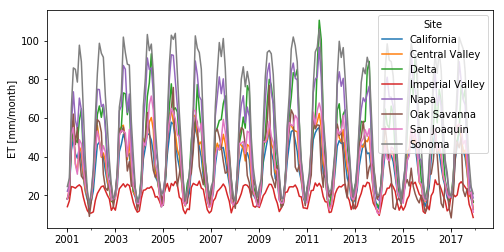

In [25]:
# load features
fts = [ee.Feature(ee.FeatureCollection("users/daviddralle/ca_et/CA").first()), 
       ee.Feature(ee.FeatureCollection("users/daviddralle/ca_et/delta").first()),
       ee.Feature(ee.FeatureCollection("users/daviddralle/ca_et/napa_ava").first()),
       ee.Feature(ee.FeatureCollection("users/daviddralle/ca_et/imperial_valley").first()),
       ee.Feature(ee.FeatureCollection("users/daviddralle/ca_et/oak_savanna").first()),
       ee.Feature(ee.FeatureCollection("users/daviddralle/ca_et/sonoma_ava").first()),
       ee.Feature(ee.FeatureCollection("users/daviddralle/ca_et/san_joaquin").first()),
       ee.Feature(ee.FeatureCollection("users/daviddralle/ca_et/central_valley").first()),
      ]

names = ['California','Delta', 'Napa', 'Imperial Valley', 'Oak Savanna', 'Sonoma', 'San Joaquin', 'Central Valley']
fts = [fts[i].set('Site', names[i]) for i in range(len(fts))]
dfs = []
for i,ft in enumerate(fts):
    et_ft = et.reduceRegion(reducer=ee.Reducer.mean(), geometry=ft.geometry(), maxPixels=1e13).getInfo()
    bands = [item for item in et_ft.keys()]
    datelist = [pd.to_datetime(band[1:]) for band in bands]
    vals = [item for item in et_ft.values()]
    temp = pd.DataFrame.from_dict({'Site':names[i], 'ET':vals})
    temp.index = datelist
    temp = temp.sort_index()
    dfs.append(temp)
    
df_long = pd.concat(dfs)
df = df_long.pivot(columns='Site', values='ET')
f, ax = plt.subplots(1, figsize=(8,4))
df.plot(ax=ax)
ax.set_ylabel('ET [mm/month]')
df.to_csv('../data/et_regions_2001-2017.csv')

## Bioregions extractions

In [68]:
regions = ee.FeatureCollection('users/daviddralle/ca_et/bioregions')
regions_list = regions.toList(500).getInfo()

names = {}
for item in regions_list:
    names[item['properties']['INACNUM']] = item['properties']['INACNAME']
# areas = {num:0 for num in list(names)}
# for item in regions_list:
#     a = ee.Feature(item).area().getInfo()
#     areas[item['properties']['INACNUM']] = areas[item['properties']['INACNUM']]+a
    
regions_image = regions.reduceToImage(['INACNUM'], ee.Reducer.first())
dfs = []
for num in list(names):
    region = regions_image.eq(num)
    et_in_region = et.updateMask(region)
    reduced = et_in_region.reduceRegion(ee.Reducer.mean(), maxPixels=1e13, scale=5000).getInfo()
    bands = [item for item in reduced.keys()]
    datelist = [pd.to_datetime(band[1:]) for band in bands]
    vals = [item for item in reduced.values()]
    temp = pd.DataFrame.from_dict({'Bioregion':names[num], 'ET':vals})
    temp.index = datelist
    temp = temp.sort_index()
    dfs.append(temp)
    
df_long = pd.concat(dfs)
df = df_long.pivot(columns='Bioregion', values='ET')
f, ax = plt.subplots(1, figsize=(8,4))
df.plot(ax=ax)
ax.set_ylabel('ET [mm/month]')
df.to_csv('../data/et_bioregions_2001-2017.csv')